In [1]:
%matplotlib inline

import pandas
import matplotlib.pyplot

In [5]:
train_df = pandas.DataFrame.from_csv("data/train_labels.csv", index_col="id")
train_df.head(10)

,date,restaurant_id,*,**,***
id,,,,,
589,2010-02-02,KAoKWjog,3,0,1
28589,2009-12-10,p038M4om,2,0,0
31170,2008-07-16,B1oXymOV,4,0,0
2600,2015-01-30,m0oWJl3G,1,0,3
1016,2012-03-19,rJoQwlEV,0,0,0
10904,2010-02-10,rNo6Ag36,0,0,0
6805,2012-12-30,V430G4EB,0,0,0
30877,2010-09-17,lnOReVoN,1,1,0
284,2010-03-18,njoZ9y3r,6,0,0


In [12]:
submit_df = pandas.DataFrame.from_csv("submission_prediction.csv", index_col="id")
submit_df.head(10)

,date,restaurant_id,*,**,***
id,,,,,
14916,2014-12-17,nkOvZOBW,3,0,1
29767,2013-12-30,WwOaAnOB,3,0,1
29338,2011-04-08,we39kvOk,3,0,1
7219,2013-12-30,dj3d5Xo9,3,0,0
20979,2008-03-31,XJ3rBW3R,4,0,1
5599,2014-08-07,lnORVGON,2,0,1
32994,2013-10-31,XJ3r0YOR,0,0,0
23804,2013-07-02,dj3dP739,4,1,2
1416,2012-01-24,JGoNpdEL,2,0,0


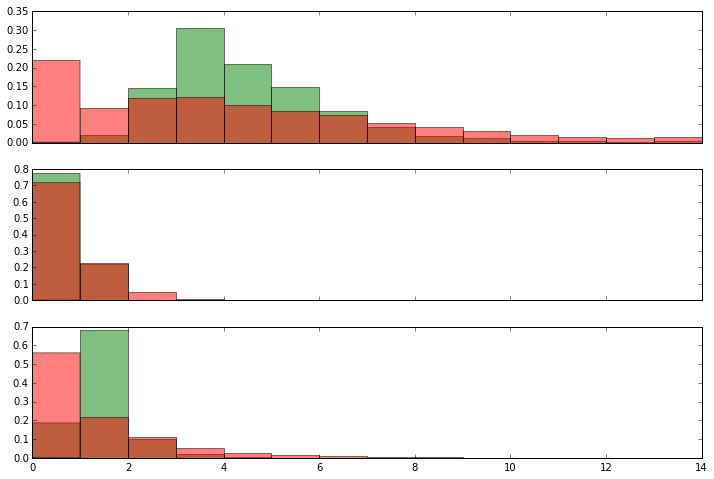

In [31]:
fig, axs = matplotlib.pyplot.subplots(3, sharex=True)
fig.set_size_inches(12, 8)

for i, label in enumerate(['*', '**', '***']):
    submit_data = submit_df.reset_index()[label]
    train_data = train_df.reset_index()[label]
    axs[i].hist(submit_data, normed=True, bins=range(0, 15), facecolor='green', alpha=0.5)
    axs[i].hist(train_data, normed=True, bins=range(0, 15), facecolor='red', alpha=0.5)